# Stock Price Prediction From Employee / Job Market Information
## Review of Cross Correlation Findings
Objective: critically review my cross correlation findings to understand if my initial results indicate predictice power of merely agreement in trend.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

# Utilities
from utils import *

%matplotlib inline
PATH = Path('D:\data\jobs')

## Load Data
Datasource: [Thinknum](https://www.thinknum.com/) [linkedIn dataset](https://blog.thedataincubator.com/tag/data-sources/)

In [14]:
%%capture 
#ignore output warnings for now
link, companies, stocks = data_load(PATH)

## Initial Findings: High Correlation between Stock Price and Employee Count
I initially found that correlations between stock prices and employee count (as self reported via the LinkedIn data) could be seen for a number of companies. I also found that there were differeing optimal lag values that maximised the correlation suggesting that for some companies stock price led employee count, while for others employee count led stock price.

However the initial analysis was run on no-stationary data, so all the correlation was showing was that for many companies the general trends of the series are similar. Further review of the analysis suggests that there is little evidence that employee count can predict short term price movement.

Note: A negative lag value here indicates *employee count leads the stock data*, while a positive lag value indicates *stock data leads employee count*.

In [15]:
# import helper functions
from cross_correlation import cross_correlation_plot, correlation

GS Goldman Sachs
Max correlation at t=0
Max correlation:0.9090720593390305


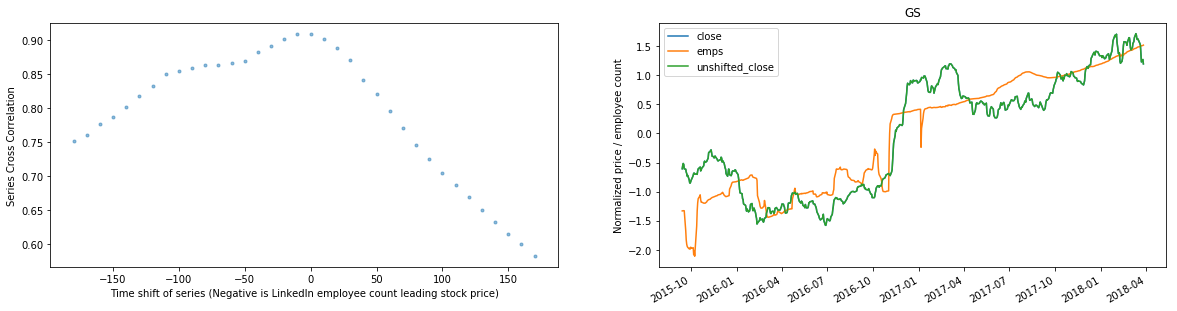

MSFT Microsoft
Max correlation at t=170
Max correlation:0.798022458728359


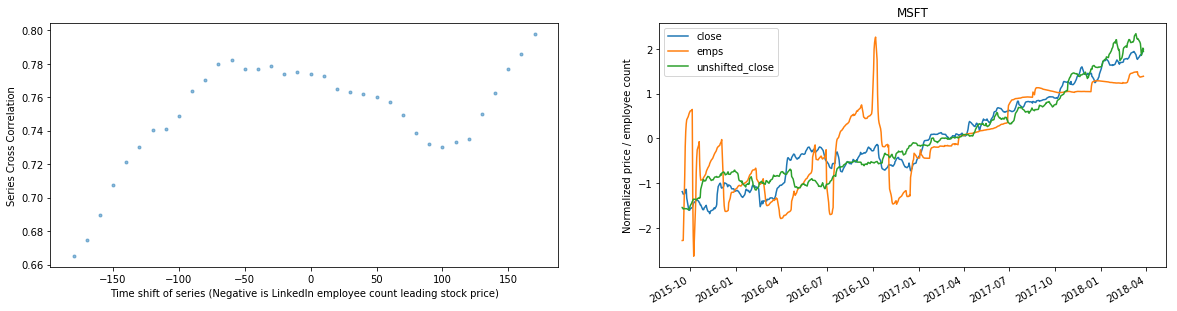

UTX United Technologies
Max correlation at t=170
Max correlation:0.11804771512609726


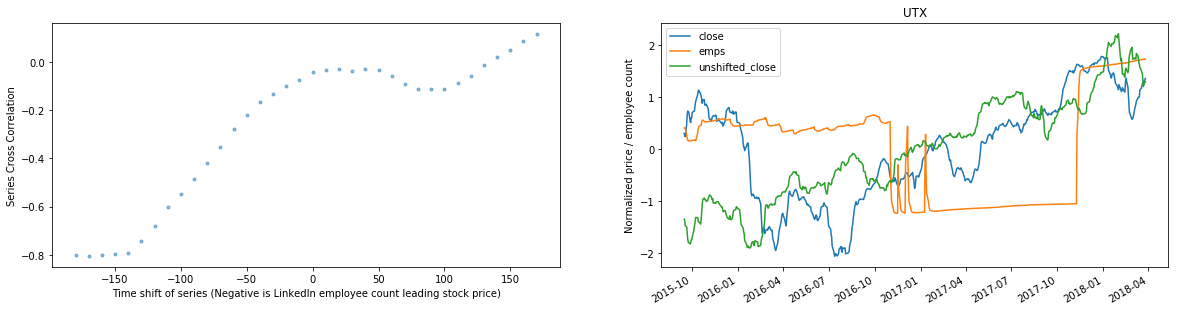

In [16]:
sample = companies.head(3).copy()

cors = np.full(len(sample),np.nan)
lags = np.full(len(sample),np.nan)
cord = {}

for i,x in enumerate(sample.iterrows()):
    print(x[1].Symbol,x[1].company_name)
    did = x[1].dataset_id
    sym = x[1].Symbol
    
    try:
        ticker = stocks[sym]
        emps = link[link['dataset_id'] == did]['employees_on_platform']
    except:
        print("Can't compute correlation")
        continue

    
    df,l,c,cd = cross_correlation_plot(ticker,emps,srange=(-180,180),smoothing=3, plot=True, resolution=10)
    plt.show()
    
    cors[i] = c
    lags[i] = l
    cord[i] = cd
    
sample['max_corr'] = cors
sample['best_lag'] = lags

Observations about the above plots:

| Symbol | Company | Comment |
| ----------- | ----------- | ----------- |
| GS | Goldman Sachs | High maximum correlation with no time lag, suggesting the employee count and stock price are well correlated, but employee count may not predict stock price that well (lower correlation at negative lags).|
| MSFT | Microsoft | Employee data agrees in trend, but some smoothing needs to be done. Some correlation in general trend of the series. |
| UTX | United Technologies | Low correlation between the series. Low predictive power. |

### Evaluating statistics for all companies
I then ran the above for all of the remaining stock symbols in the `companies` DataFrame, and saved to a .csv.

In [17]:
correlations = pd.read_csv(PATH/'extracted_correlations_all.csv')

In [18]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [19]:
from bokeh.palettes import brewer, Viridis256
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

def plot_cor(correlations):
    source = ColumnDataSource(correlations)
    colors = linear_cmap(field_name='IPOyear',palette=Viridis256, low=1980,high=2018)

    TOOLS="hover, box_zoom,reset,tap,save,box_select,poly_select,lasso_select"
    p1 = figure(title="Optimal Correlation and Timeshift Parameters", toolbar_location="above",
                width=900, height=500, tools=TOOLS)

    p1.circle(x='best_lag', y = 'max_corr', source=source, fill_color=colors,
               fill_alpha=0.9, line_color=None, size=13)

    p1.xaxis.axis_label = 'Timeshift, days (negative: employee count leads stock price; positive: stocks lead employee count)'
    p1.yaxis.axis_label = 'Maximum series correlations'

    hover = p1.select(dict(type=HoverTool))
    hover.tooltips = [
            ("Name", "@Name"),
            ("IPO Year", "@IPOyear"),
            ("Correlation", "@max_corr"),
            ("Optimal Lag", "@best_lag"),
            ]


    show(p1)

plot_cor(correlations)

Colour scale = IPO Year
- **Middle Band** (abs(correlations) < 0.8): Low evidence of correlation between series.
- **Upper Left Quadrant**: Employee count may be predictive of stock value in the future.
- **Upper Right Quadrant**: Evidence that employee count reacts to stock price movement.
- **Bottom Left Quadrant**: Increase in employee count in past, correlates with a decrease in stock prices in the future.
- **Bottom Right Quadrant**: Increase in stock price correlated with a decrease in employee count in future.

## Doing the same analysis as above but using the differenced data

Instead of using the daily stock price, I rerun the analysis using the daily differenced stock price which removes the general trend and is (nearly) a stationary series.

In [20]:
from cross_correlation import correlation_w_diff, cross_correlation_plot_w_diff

GS Goldman Sachs
Max correlation at t=90
Max correlation:0.06786561918955271


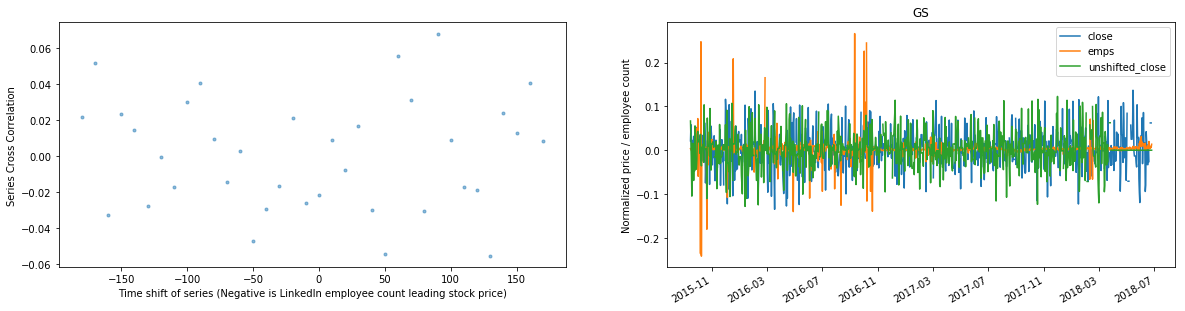

MSFT Microsoft
Max correlation at t=130
Max correlation:-0.0649130990678906


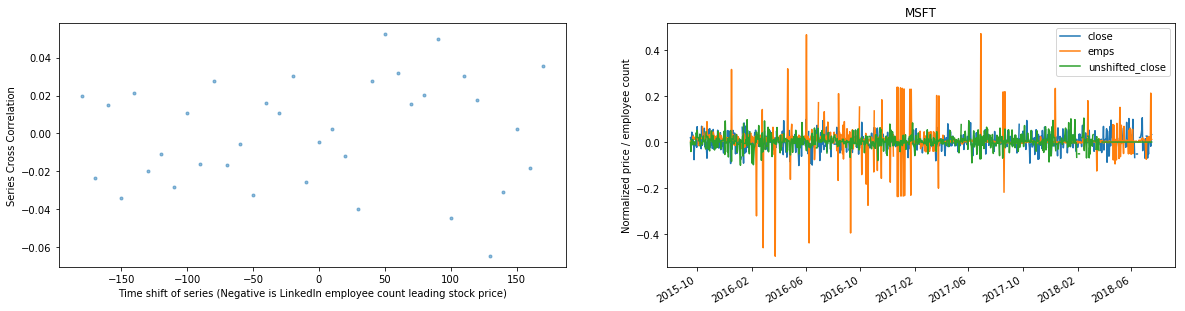

UTX United Technologies
Max correlation at t=-120
Max correlation:-0.10553936179057487


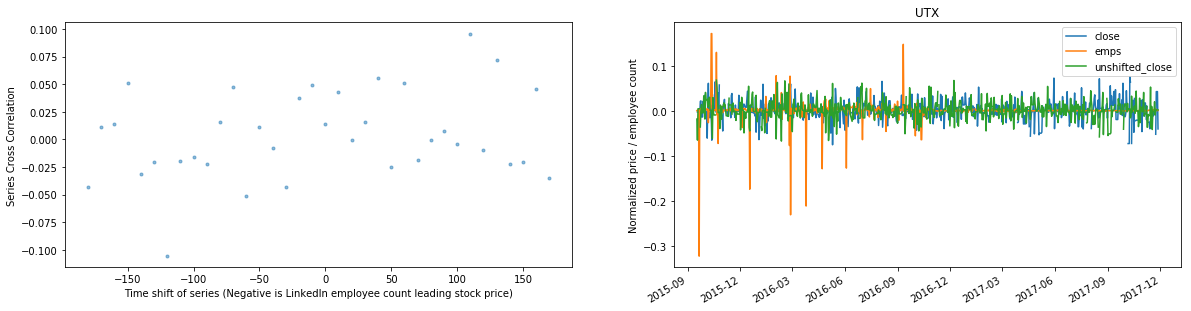

In [21]:
sample = companies.head(3).copy()

cors = np.full(len(sample),np.nan)
lags = np.full(len(sample),np.nan)
cord = {}

for i,x in enumerate(sample.iterrows()):
    print(x[1].Symbol,x[1].company_name)
    did = x[1].dataset_id
    sym = x[1].Symbol
    
    try:
        ticker = stocks[sym]
        emps = link[link['dataset_id'] == did]['employees_on_platform']
    except:
        print("Can't compute correlation")
        continue

    
    df,l,c,cd = cross_correlation_plot_w_diff(ticker,emps,srange=(-180,180),smoothing=3, plot=True, resolution=10)
    plt.show()
    
    cors[i] = c
    lags[i] = l
    cord[i] = cd
    
sample['max_corr'] = cors
sample['best_lag'] = lags

As you can see the correlations that we observed with the daily price data has completely dissapeared from the daily difference data.

I can rerun the analysis for all stocks.

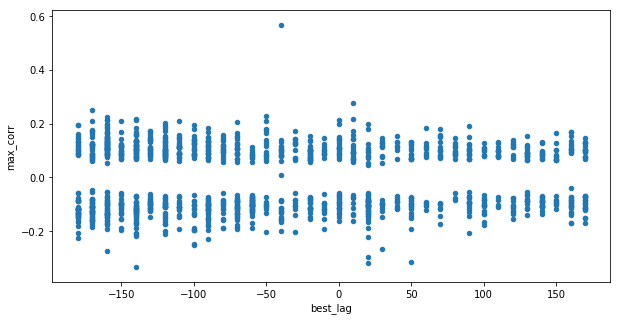

In [31]:
correlations = pd.read_csv(PATH/'daily_diff_cross_correlations.csv')
# plot_cor(correlations);
correlations[['max_corr','best_lag']].plot(kind='scatter',x='best_lag',y='max_corr',figsize=(10,5));

This looks much less clear, although there are a few outliers.

I can go further than this and show that if I simulate the daily differences naively as a normally distributed random variable, I obtain very similar results.

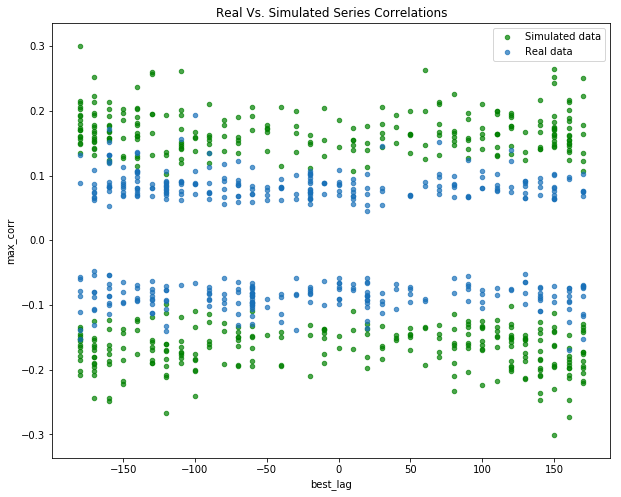

In [6]:
# Using subset of data due to issues saving .ipynb file with large outputs
# Load Simulated Data
correlations_sim = pd.read_csv(PATH/'simulated_daily_diff_ccf.csv')
correlations_sim.columns = ['max_corr','best_lag']
correlations_sim['sim'] = 1
correlations_sim = correlations_sim[:500]

# Load actual data
correlations = pd.read_csv(PATH/'daily_diff_cross_correlations.csv',index_col=0)
correlations = correlations[['max_corr','best_lag']]
correlations['sim'] = 0
correlations = correlations[:500]

# Plot
ax = correlations_sim.plot(kind='scatter',figsize=(10,8),alpha=0.7,x='best_lag',y='max_corr',c='g', label='Simulated data')
correlations.plot(kind='scatter',ax=ax,alpha=0.7,x='best_lag',y='max_corr',c='#1870B8',label='Real data');
ax.set_title('Real Vs. Simulated Series Correlations');

The simulated dataset is plotted in green, and the real dataset is in blue. You can see we would expect a greater maximum correlation across a random walk than the results I have obtained. **Any correlation seen in daily data is noise**.